In [2]:
import scanpy as sc

import pyro
import pyro.distributions as dist

import torch

adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/OCT2025/spatial-transformer/models/17OCT2025/adata-cell-leiden.h5ad")
adata = adata[adata.layers["transcript"].sum(axis=1) > 100]
adata = adata[adata.obs["folder"].eq("99-15")]
adata

/home/jhaberbe/Projects/Personal/OCT2025/vi-chinese-restaurant-process/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View of AnnData object with n_obs × n_vars = 25433 × 366
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'lipid_droplet_area', 'plin2_area', 'oil_red_o_area', 'distance_to_nearest_amyloid', 'folder', 'leiden_res_0.05', 'leiden_res_0.1', 'leiden_res_0.15', 'leiden_res_0.2', 'leiden_res_0.25', 'leiden_res_0.3', 'leiden_res_0.4', 'leiden_res_0.5', 'leiden_res_0.6', 'leiden_res_0.7', 'leiden_res_0.8', 'leiden_res_0.9', 'leiden_res_1.0', 'leiden_res_1.1', 'leiden_res_1.2', 'leiden_res_1.3', 'leiden_res_1.4', 'leiden_res_1.5', 'leiden_res_1.6', 'leiden_res_1.7', 'leiden_res_1.8', 'leiden_res_1.9', 'cell_type', 'group', 'z_centroid', 'spatial_niche', 'spatial_niche_refined', 'lipid_droplet_count', 'oil_red_o_count', 'plin2_count', 'total_area', 'log_lipid_droplet_area', 'log_oil_red_o_area', 'log_plin2_area', 'folder-group', 'spa

In [3]:
import numpy as np

log_exposure = np.log(adata.layers["transcript"].sum(axis=1) / adata.layers["transcript"].sum(axis=1).mean())

device="cuda"
data = {
    "counts": torch.tensor(adata.layers["transcript"]).float().to(device),
    "log_exposure": torch.tensor(log_exposure).float().to(device)
}

In [4]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn.functional as F

def stick_breaking(v, eps=1e-5):
    # v: [K]
    one_minus_v = torch.clamp(1 - v, min=eps)
    remaining_stick = torch.cat([
        torch.tensor([1.], device=v.device), 
        one_minus_v.cumprod(dim=0)[:-1]
    ])
    return v * remaining_stick  # shape: [K]

In [5]:
def model(data, K = 40):
    device = data["counts"].device
    N, F = data["counts"].shape

    crp_alpha = pyro.sample(
        "crp_alpha",
        dist.LogNormal(3, .5)
    )
    crp_alpha_stable = torch.clamp(crp_alpha, min=1e-3, max=1e3)

    v_k = pyro.sample(
        "v_k",
        dist.Beta(
            torch.ones(K, device=device), 
            crp_alpha.expand(K)
        ).to_event(1)
    )
    pi_k = stick_breaking(v_k)


    pi_logits_loc = torch.zeros(K, F, device=device) - 2
    pi_logits_scale = torch.ones(K, F, device=device) * 0.3
    pi_logits = pyro.sample(
        "pi_logits",
        dist.Normal(
            pi_logits_loc,
            pi_logits_scale
        ).to_event(2)
    )

    nb_logits_loc = torch.zeros(K, F, device=device) - 2
    nb_logits_scale = torch.ones(K, F, device=device) * 0.3
    nb_logits = pyro.sample(
        "nb_logits",
        dist.Normal(
            nb_logits_loc,
            nb_logits_scale
        ).to_event(2)
    )

    total_count_loc = torch.zeros(K, F, device=device) - 2
    total_count_scale = torch.ones(K, F, device=device) * 0.3
    total_count = pyro.sample(
        "total_count",
        dist.LogNormal(
            total_count_loc,
            total_count_scale
        ).to_event(2)
    )

    log_exposure_expanded = data["log_exposure"].unsqueeze(1).unsqueeze(2)

    pi_logits_expanded = pi_logits.unsqueeze(0).expand(N, K, F)
    nb_logits_expanded = nb_logits.unsqueeze(0).expand(N, K, F)
    total_count_expanded = total_count.unsqueeze(0).expand(N, K, F)

    nb_logits = nb_logits_expanded + log_exposure_expanded
    zero_inflation_logits = pi_logits_expanded + log_exposure_expanded

    pyro.sample(
        "obs",
        dist.MixtureSameFamily(
            mixture_distribution=dist.Categorical(pi_k).expand([N]),
            component_distribution=dist.Independent(
                dist.ZeroInflatedDistribution(
                    base_dist=dist.NegativeBinomial(
                        logits=nb_logits,
                        total_count=total_count_expanded.exp()
                    ),
                    gate_logits=zero_inflation_logits
                ),
                reinterpreted_batch_ndims=1
            )
        ).to_event(1),
        obs=data["counts"]
    )

def guide(data, K = 40):
    device = data["counts"].device
    N, F = data["counts"].shape

    crp_alpha_loc = pyro.param(
        "crp_alpha_loc",
        torch.ones(1, device=device) * 3,
        constraint=dist.constraints.real
    )
    crp_alpha_scale = pyro.param(
        "crp_alpha_scale",
        torch.ones(1, device=device) * 0.5,
        constraint=dist.constraints.positive
    )
    crp_alpha = pyro.sample(
        "crp_alpha",
        dist.LogNormal(
            crp_alpha_loc,
            crp_alpha_scale
        )
    )
    crp_alpha_stable = torch.clamp(
        crp_alpha,
        min=1e-3,
        max=1e3
    )

    v_k_alpha = pyro.param(
        "v_k_alpha",
        torch.ones(K, device=device),
        constraint=dist.constraints.positive
    )
    v_k_beta = pyro.param(
        "v_k_beta",
        torch.ones(K, device=device),
        constraint=dist.constraints.positive
    )
    v_k = pyro.sample(
        "v_k",
        dist.Beta(
            v_k_alpha, 
            v_k_beta
        ).to_event(1)
    )
    pi_k = stick_breaking(v_k)

    pi_logits_loc = pyro.param(
        "pi_logits_loc",
        torch.zeros(K, F, device=device) - 2,
        constraint=dist.constraints.real
    )
    pi_logits_scale = pyro.param(
        "pi_logits_scale",
        torch.ones(K, F, device=device) * 0.3,
        constraint=dist.constraints.positive
    )
    pi_logits = pyro.sample(
        "pi_logits",
        dist.Normal(
            pi_logits_loc,
            pi_logits_scale
        ).to_event(2)
    )

    nb_logits_loc = pyro.param(
        "nb_logits_loc",
        torch.zeros(K, F, device=device) - 2,
        constraint=dist.constraints.real
    )
    nb_logits_scale = pyro.param(
        "nb_logits_scale",
        torch.ones(K, F, device=device) * 0.3,
        constraint=dist.constraints.positive
    )
    nb_logits = pyro.sample(
        "nb_logits",
        dist.Normal(
            nb_logits_loc,
            nb_logits_scale
        ).to_event(2)
    )

    total_count_loc = pyro.param(
        "total_count_loc",
        torch.zeros(K, F, device=device) - 2,
        constraint=dist.constraints.real
    )
    total_count_scale = pyro.param(
        "total_count_scale",
        torch.ones(K, F, device=device) * 0.3,
        constraint=dist.constraints.positive
    )
    total_count = pyro.sample(
        "total_count",
        dist.LogNormal(
            total_count_loc,
            total_count_scale
        ).to_event(2)
    )

In [6]:
import pyro
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import torch
from tqdm import trange
import matplotlib.pyplot as plt

pyro.clear_param_store()
# --- SVI setup ---
base_lr = 1e-1
optimizer = optim.ClippedAdam({"lr": base_lr, "clip_norm": 3.0})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# --- Helpers ---
def expected_stick_breaking_weights(v_k_alpha, v_k_beta):
    mean_v = v_k_alpha / (v_k_alpha + v_k_beta)
    remaining_stick = torch.cat(
        [torch.tensor([1.], device=mean_v.device),
         (1 - mean_v).cumprod(dim=0)[:-1]]
    )
    return mean_v * remaining_stick

def effective_num_clusters(pi_k, threshold=1e-3):
    return torch.sum(pi_k > threshold).item()

# --- Adaptive LR scaling ---
def compute_adaptive_lr(loss, avg_loss, base_lr=1e-3, factor=0.3):
    """
    Scales the LR based on ratio of current loss to moving average loss.
    If loss > avg_loss → increase LR (learning faster).
    If loss < avg_loss → decrease LR (fine-tuning).
    """
    ratio = torch.clamp(torch.tensor(loss / (avg_loss + 1e-8)), 0.1, 10.0)
    scaled_lr = base_lr * (ratio ** factor)
    return float(torch.clamp(scaled_lr, 1e-5, 1e-2))  # keep within safe bounds

# --- Training loop ---
num_steps = 2000
losses = []
ema_loss = None  # exponential moving average of ELBO

progress_bar = trange(num_steps, desc="Training", leave=True)
for step in progress_bar:
    loss = svi.step(data)
    losses.append(loss)

    # --- Update moving average of ELBO ---
    if ema_loss is None:
        ema_loss = loss
    else:
        ema_loss = 0.95 * ema_loss + 0.05 * loss

    # --- Adapt learning rate based on loss dynamics ---
    new_lr = compute_adaptive_lr(loss, ema_loss, base_lr=base_lr)
    optimizer = optim.ClippedAdam({"lr": new_lr, "clip_norm": 10.0})

    # --- Compute effective clusters every few steps ---
    if step % 2 == 0:
        if "v_k_alpha" in pyro.get_param_store() and "v_k_beta" in pyro.get_param_store():
            v_k_alpha = pyro.param("v_k_alpha").detach()
            v_k_beta = pyro.param("v_k_beta").detach()
            pi_k = expected_stick_breaking_weights(v_k_alpha, v_k_beta)
            n_eff = effective_num_clusters(pi_k)
        else:
            n_eff = float("nan")

        progress_bar.set_postfix({
            "ELBO": f"{loss:.2f}",
            "K_eff": f"{n_eff:.0f}",
            "LR": f"{new_lr:.2e}"
        })

Training:   8%|▊         | 157/2000 [00:41<08:10,  3.75it/s, ELBO=6535060.44, K_eff=6, LR=1.00e-02] 


KeyboardInterrupt: 

/home/jhaberbe/Projects/Personal/OCT2025/vi-chinese-restaurant-process/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jhaberbe/Projects/Personal/OCT2025/vi-chinese-restaurant-process/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


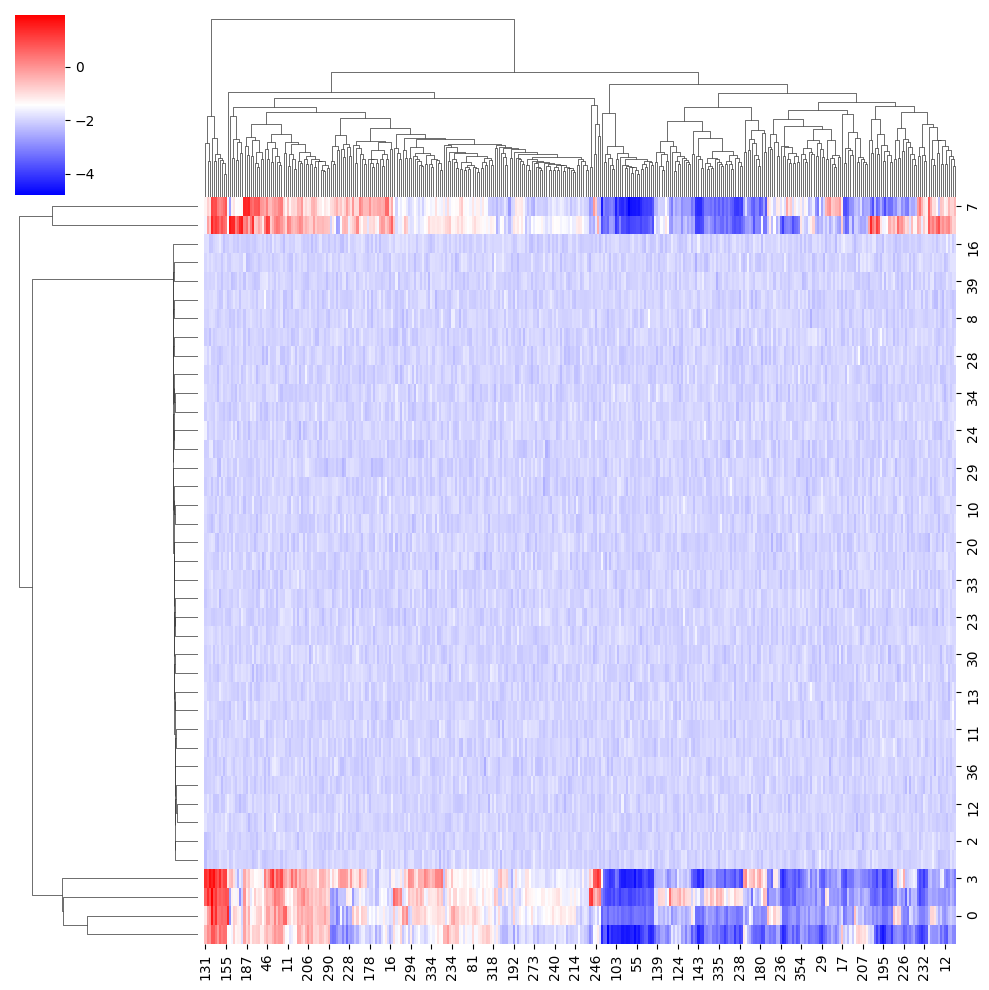

In [7]:
import seaborn as sns
sns.clustermap(
    dict(pyro.get_param_store())["nb_logits_loc"].detach().cpu().numpy(),
    cmap="bwr"
)

/home/jhaberbe/Projects/Personal/OCT2025/vi-chinese-restaurant-process/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jhaberbe/Projects/Personal/OCT2025/vi-chinese-restaurant-process/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


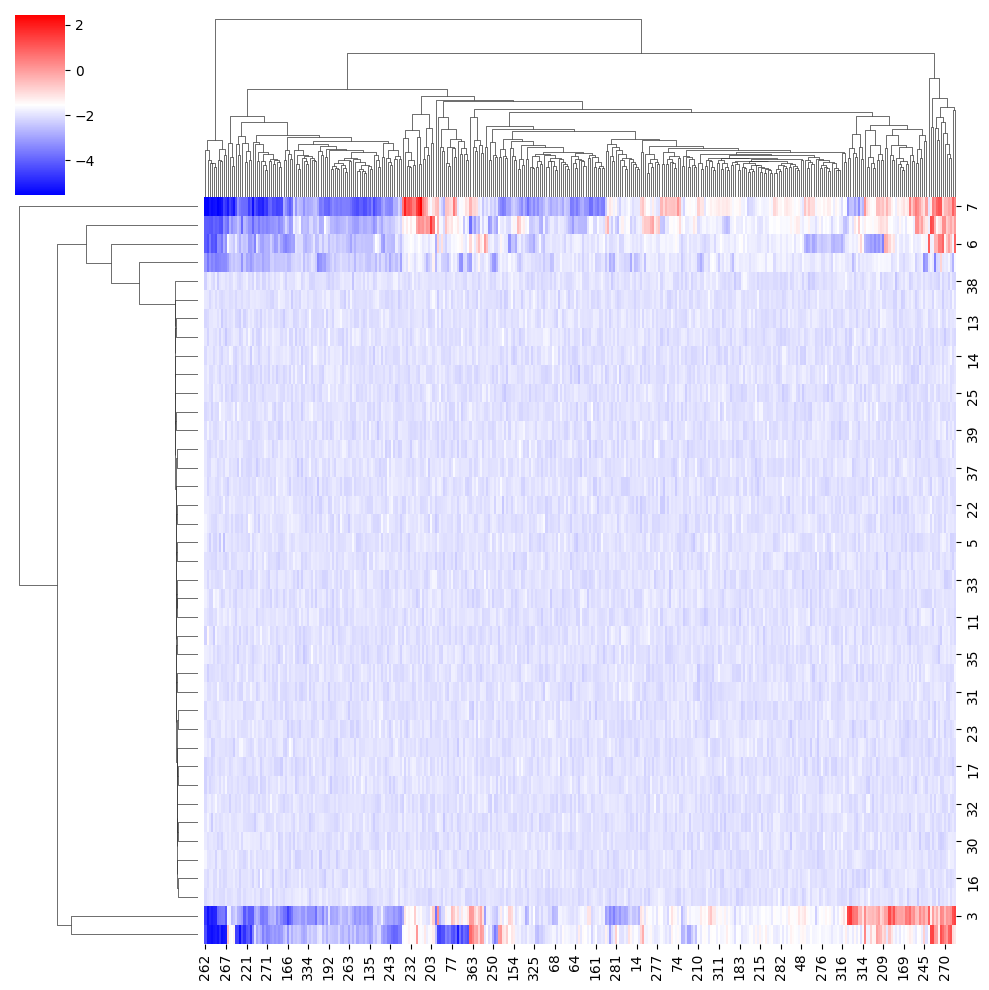

In [8]:
import seaborn as sns
sns.clustermap(
    dict(pyro.get_param_store())["pi_logits_loc"].detach().cpu().numpy(),
    cmap="bwr"
)

In [9]:
def predict_clusters(data, param_store=None):
    """
    Predict cluster assignments using ZINB mixture model parameters.

    Args:
        data: dict with key "counts", shape [N, F]
        param_store: Pyro param store (pyro.get_param_store())
        K: Number of clusters

    Returns:
        cluster_assignments: LongTensor of shape [N] with most likely cluster index per data point
    """
    device = data["counts"].device
    counts = data["counts"]  # [N, F]
    N, F = counts.shape

    if param_store is None:
        param_store = dict(pyro.get_param_store())

    # Stick-breaking parameters
    v_k_alpha = param_store["v_k_alpha"].detach()
    v_k_beta = param_store["v_k_beta"].detach()
    crp_alpha = param_store.get("crp_alpha", torch.tensor(1.0, device=device)).detach()

    # Compute mean of Beta and stick-breaking weights
    v_k = v_k_alpha / (v_k_alpha + v_k_beta * crp_alpha)  # mean of Beta, shape [K]
    pi_k = stick_breaking(v_k)  # shape [K]

    # Cluster parameters
    logits_loc = param_store["nb_logits_loc"].detach()        # [K, F]
    total_count_loc = param_store["total_count_loc"].detach()  # [K, F]
    pi_logits_loc = param_store["pi_logits_loc"].detach()  # gate logits for zero inflation [K, F]
    K = logits_loc.shape[0]

    total_count = total_count_loc.exp()                    # ensure positive total_count [K, F]
    logits = logits_loc                                      # NB logits [K, F]
    gate_logits = pi_logits_loc                              # gate logits for zero inflation [K, F]

    # Compute log likelihoods per cluster for each data point
    log_probs = []
    for k in range(K):
        # Base Negative Binomial distribution for cluster k
        nb_dist = dist.NegativeBinomial(total_count=total_count[k], logits=logits[k])

        # Zero-inflated distribution
        zinb_dist = dist.ZeroInflatedDistribution(
            base_dist=nb_dist,
            gate_logits=gate_logits[k]
        )

        # Log prob for all data points and features: shape [N, F]
        log_prob_nf = zinb_dist.log_prob(counts)  

        # Sum over features to get [N]
        log_prob_n = log_prob_nf.sum(dim=-1)

        log_probs.append(log_prob_n)  # list of [N]

    # Stack over clusters -> shape [N, K]
    log_probs = torch.stack(log_probs, dim=1)

    # Add log mixture weights (prior)
    log_pi = torch.log(pi_k + 1e-8)  # [K]
    log_probs += log_pi.unsqueeze(0)  # broadcast over [N, K]

    # Most likely cluster assignment per data point
    cluster_assignments = log_probs.argmax(dim=-1)  # [N]

    return cluster_assignments.detach().cpu()

clusters = predict_clusters(data)

In [10]:
adata.obs["clusters"] = clusters

/tmp/ipykernel_1796910/1340808956.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["clusters"] = clusters


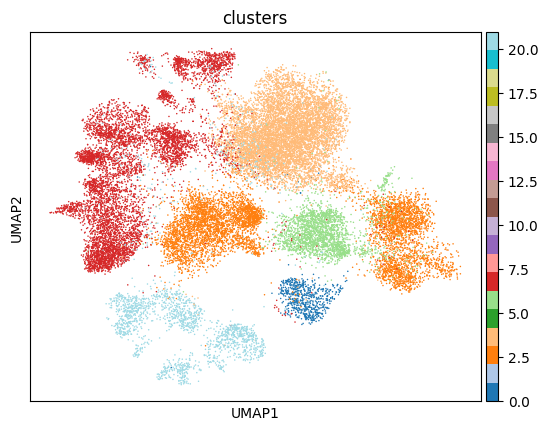

In [ ]:
dc.pl.umap(adata, color="clusters", cmap="tab20")

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

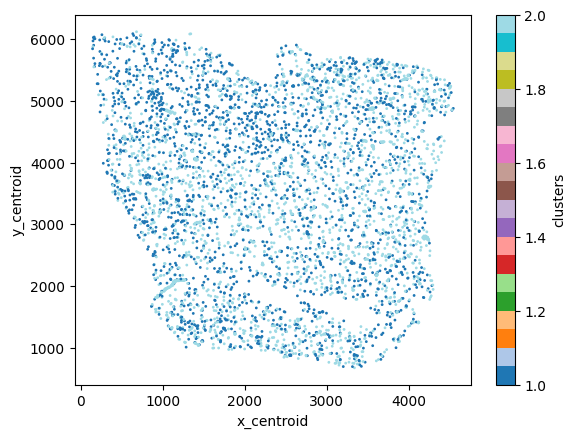

In [41]:
adata.obs.plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="clusters",
    cmap="tab20", 
    s=1
)